In [1]:
__copyright__ = "Reiner Lemoine Institut gGmbH"
__license__ = "GNU Affero General Public License Version 3 (AGPL-3.0)"
__url__ = "https://github.com/openego/eDisGo/blob/master/LICENSE"
__author__ = "gplssm, birgits, khelfen"

# eDisGo basic example

This example shows you the first steps with eDisGo. Grid expansion costs for an example distribution grid are calculated assuming renewable and conventional power plant capacities as stated in the scenario framework of the German Grid Development Plan 2015 (Netzentwicklungsplan) for the year 2035 (scenario B2). Through this, the data structure used in eDisGo is explained and it is shown how to get distribution grid data, how to use the automatic grid reinforcement methodology to determine grid expansion needs and costs and how to evaluate your results.


### Learn more about eDisGo

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

### Table of Contents


* [Installation](#installation)
* [Settings](#settings)
* [eDisGo data structure](#network)
* [Future generator scenario](#generator_scenario)
* [Grid reinforcement](#grid_reinforcement)
* [Results evaluation](#evaluation)
* [References](#references)

## Installation <a class="anchor" id="installation"></a>

This notebook requires a working installation of eDisGo as well as `jupyter notebook` to run the example and `contextily` and `geopandas` to view the grid topology on a map. You can install all of these as follows:

```python
pip install eDisGo[examples,geoplot]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/features-refactoring/quickstart.html#installation) for more information.

#### Import packages

In [2]:
import os
import requests
import sys

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from edisgo import EDisGo

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



### Settings <a class="anchor" id="settings"></a>

The class **EDisGo** serves as the top-level API for
setting up your scenario, invocation of data import, power flow analysis, grid reinforcement and flexibility measures. It also provides access to all relevant data. See the [class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) for more information.

To set up a scenario to do a worst-case analysis that considers the heavy load flow and reverse power flow cases used in distribution grid planning, you simply have to provide a grid and set the 'worst_case_analysis' parameter, which is both explained in the following two sections. 

#### Distribution grid data

Currently, synthetic grid data generated with the python project
[ding0](https://github.com/openego/ding0)
is the only supported data source for distribution grid data. ding0 provides the grid topology data in the form of csv files, with separate files for buses, lines, loads, generators, etc. You can retrieve ding0 data from
[Zenodo](https://zenodo.org/record/890479)
(make sure you choose latest data) or check out the
[Ding0 documentation](https://dingo.readthedocs.io/en/dev/usage_details.html#ding0-examples)
on how to generate grids yourself. A ding0 example grid can be viewed [here](https://github.com/openego/eDisGo/tree/features/refactoring/tests/ding0_test_network_2). It is possible to provide your own grid data if it is in the same format as the ding0 grid data. 

This example works with any ding0 grid data. If you don't have grid data yet, you can execute the following to download the example grid data mentioned above.

In [3]:
import requests

def download_ding0_example_grid():

    # create directories to save ding0 example grid into
    ding0_example_grid_path = os.path.join(
        os.path.expanduser("~"), ".edisgo", "ding0_test_network"
    )
    os.makedirs(ding0_example_grid_path, exist_ok=True)

    # download files
    filenames = [
        "buses",
        "generators",
        "lines",
        "loads",
        "network",
        "switches",
        "transformers",
        "transformers_hvmv",
    ]

    for file in filenames:
        req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/ding0_test_network_2/{}.csv".format(
                file
            )
        )
        filename = os.path.join(ding0_example_grid_path, "{}.csv".format(file))
        with open(filename, "wb") as fout:
            fout.write(req.content)


download_ding0_example_grid()

The ding0 grid you want to use in your analysis is specified through the input parameter 'ding0_grid' of the EDisGo class. The following assumes you want to use the ding0 example grid downloaded above. To use a different ding0 grid, just change the path below.

In [4]:
ding0_grid = os.path.join(os.path.expanduser("~"), ".edisgo", "ding0_test_network")

#### Specifying worst-cases

In conventional grid expansion planning worst-cases, the heavy load flow and the reverse power flow, are used to determine grid expansion needs. eDisGo allows you to analyze these cases separately or together. Choose between the following options:

* **’feed-in_case’** 
  
  Feed-in and demand for the worst-case scenario "reverse power flow" are generated. Demand is by default set to 15% of maximum demand  for loads connected to the MV grid and 10% for loads connected to the LV grid. Feed-in of all generators is set to the nominal power of the generator, except for PV systems where it is by default set to 85% of the nominal power.

  
* **’load_case’**

  Feed-in and demand for the worst-case scenario "heavy load flow" are generated. Demand of all loads is by default set to maximum demand; feed-in of all generators is set to zero.


* **’worst-case’**
  
By default both cases are determined.

Feed-in and demand in the two worst-cases are defined in the [config file 'config_timeseries.cfg'](https://edisgo.readthedocs.io/en/latest/configs.html#config-timeseries) and can be changed by setting different values in the config file. 

Instead of doing a worst-case analysis you can also provide your own timeseries for demand and feed-in and use those in the power flow analysis. EDisGo also offers methods to generate load and feed-in time series. Check out the [EDisGo class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) and examples in the [getting started documentation section](https://edisgo.readthedocs.io/en/dev/quickstart.html#a-minimum-working-example) for more information.

In [5]:
cases = ["load_case", "feed-in_case"]

Now we are ready to initialize the edisgo object.

In [6]:
edisgo = EDisGo(ding0_grid=ding0_grid)
edisgo.set_time_series_worst_case_analysis(cases=cases)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version None.

INFO:pypsa.io:Imported network ding0_test_network has buses, generators, lines, loads, transformers
/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### eDisGo data structure <a class="anchor" id="network"></a>

As stated above, the EDisGo class serves as the top-level API and provides access to all relevant data. It also enables plotting of the grid topology. In order to have a look at the MV grid topology, you can use the following plot.

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



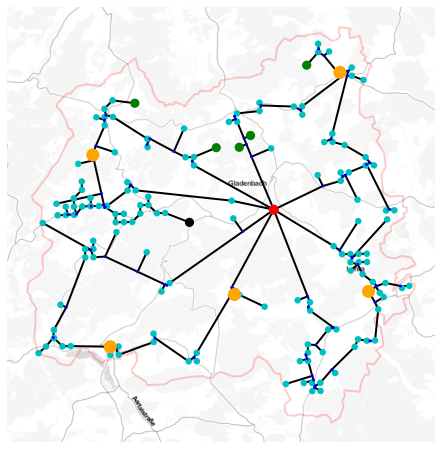

In [7]:
edisgo.plot_mv_grid_topology(technologies=True)

Here, red nodes stand for the substation's secondary side, light blue nodes for distribution substation's primary sides, green nodes for nodes fluctuating generators are connected to, grey nodes for disconnecting points and dark blue nodes show branch tees.
Underlying LV grids are not georeferenced in ding0, wherefore a plotting for LV grids analog to the one shown above is not provided. A different possibility to get a graphical representation of LV grids is shown later in this example. Let's first get into eDisGo's data structure.

Grid data is stored in the [Topology](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.topology.Topology) class.
Time series data can be found in the [TimeSeries](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.timeseries.TimeSeries) class. Results data holding results e.g. from the power flow analysis and grid expansion is stored in the [Results](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.results.Results) class.
Configuration data from the config files (see [default_configs](https://edisgo.readthedocs.io/en/features-refactoring/configs.html#default-configuration-data)) is stored
in the [Config](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.tools.html#edisgo.tools.config.Config) class.
All these can be accessed as follows:

```python
edisgo.topology
edisgo.timeseries
edisgo.results
edisgo.config
```

The grid data in the Topology object is stored in pandas DataFrames.
There are extra data frames for all grid elements (buses, lines, switches, transformers), as well as generators, loads and storage units.
You can access those dataframes as follows:

In [8]:
# Access all buses in MV grid and underlying LV grids
# .head() enables only viewing the first entries of the dataframe
edisgo.topology.buses_df.head()

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
Bus,,,,,,
Busbar_mvgd_460_MV,20.0,8.583030,50.756205,460,NaN,False
BusBar_mvgd_460_lvgd_127330_MV,20.0,8.606737,50.685368,460,NaN,False
BusBar_mvgd_460_lvgd_127329_MV,20.0,8.601547,50.688542,460,NaN,False
BusBar_mvgd_460_lvgd_127331_MV,20.0,8.606640,50.688604,460,NaN,False
BusBar_mvgd_460_lvgd_127332_MV,20.0,8.611830,50.685429,460,NaN,False


In [9]:
# Access all lines in MV grid and underlying LV grids
edisgo.topology.mv_grid.lines_df.head()

,bus0,bus1,length,x,r,s_nom,num_parallel,type_info,kind
Line,,,,,,,,,
Branch_Generator_mvgd_460_biogas_from_grid_874048_LVStation_mvgd_460_lvgd_135405,BusBar_mvgd_460_lvgd_135405_MV,Bus_mvgd_460_gen_874048,1.471220,0.166252,0.191259,14.445304,1.0,NA2XS2Y 3x1x240,line
Branch_Generator_mvgd_460_wind_onshore_1562360_MVCableDist_mvgd_460_69,Bus_mvgd_460_gen_1562360,BranchTee_mvgd_460_69,0.403852,0.050889,0.083194,11.050484,1.0,NA2XS2Y 3x1x150 RE/25,line
Branch_Generator_mvgd_460_wind_onshore_1562518_LVStation_mvgd_460_lvgd_136620,BusBar_mvgd_460_lvgd_136620_MV,Bus_mvgd_460_gen_1562518,1.378502,0.173704,0.283971,11.050484,1.0,NA2XS2Y 3x1x150 RE/25,line
Branch_Generator_mvgd_460_wind_onshore_1562529_MVCableDist_mvgd_460_70,Bus_mvgd_460_gen_1562529,BranchTee_mvgd_460_70,0.437507,0.055130,0.090126,11.050484,1.0,NA2XS2Y 3x1x150 RE/25,line
Branch_Generator_mvgd_460_wind_onshore_1562543_LVStation_mvgd_460_lvgd_179885,BusBar_mvgd_460_lvgd_179885_MV,Bus_mvgd_460_gen_1562543,0.986255,0.111450,0.128213,14.445304,1.0,NA2XS2Y 3x1x240,line


In [10]:
# Access all generators in MV grid and underlying LV grids
edisgo.topology.generators_df.head()

bus    p_nom  \
Generator                                                                       
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  BusBar_lac_85334  0.00900   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  BusBar_lac_85334  0.00736   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  BusBar_lac_85334  0.00960   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  BusBar_lac_85334  0.01551   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  BusBar_lac_85334  0.00400   

                                                     type control  \
Generator                                                           
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar      PQ   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar      PQ   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar      PQ   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar      PQ   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar      PQ   

                                                    weather_cell_id  \
Generator                                                             
Generator_mvgd_460_lvgd_132188_solar_roof_mount...        1124088.0   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...        1124088.0   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...        1124088.0   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...        1124088.0   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...        1124088.0   

                                                               subtype  \
Generator                                                                
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar_roof_mounted   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar_roof_mounted   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar_roof_mounted   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar_roof_mounted   
Generator_mvgd_460_lvgd_132188_solar_roof_mount...  solar_roof_mounted   

                                                   voltage_level  
Generator                                                         
Generator_mvgd_460_lvgd_132188_solar_roof_mount...            lv  
Generator_mvgd_460_lvgd_132188_solar_roof_mount...            lv  
Generator_mvgd_460_lvgd_132188_solar_roof_mount...            lv  
Generator_mvgd_460_lvgd_132188_solar_roof_mount...            lv  
Generator_mvgd_460_lvgd_132188_solar_roof_mount...            lv

The grids can also be accessed individually. The MV grid is stored in an [MVGrid](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.grids.MVGrid) object and each LV grid in an
[LVGrid](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.grids.LVGrid) object.
The MV grid topology can be accessed through:

```python
edisgo.topology.mv_grid
```

Its components can be accessed analog to those of the whole grid topology as shown above.

In [11]:
# Access all buses in MV grid
edisgo.topology.mv_grid.buses_df.head()

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
Bus,,,,,,
Busbar_mvgd_460_MV,20.0,8.583030,50.756205,460,NaN,False
BusBar_mvgd_460_lvgd_127330_MV,20.0,8.606737,50.685368,460,NaN,False
BusBar_mvgd_460_lvgd_127329_MV,20.0,8.601547,50.688542,460,NaN,False
BusBar_mvgd_460_lvgd_127331_MV,20.0,8.606640,50.688604,460,NaN,False
BusBar_mvgd_460_lvgd_127332_MV,20.0,8.611830,50.685429,460,NaN,False


In [12]:
# Access all generators in MV grid
edisgo.topology.mv_grid.generators_df.head()

,bus,p_nom,type,control,weather_cell_id,subtype,voltage_level
Generator,,,,,,,
Generator_mvgd_460_biogas_from_grid_874048,Bus_mvgd_460_gen_874048,0.58,biomass,PQ,NaN,biogas_from_grid,mv
Generator_mvgd_460_wind_onshore_1562360,Bus_mvgd_460_gen_1562360,3.05,wind,PQ,1124088.0,wind_onshore,mv
Generator_mvgd_460_wind_onshore_1562518,Bus_mvgd_460_gen_1562518,3.05,wind,PQ,1124088.0,wind_onshore,mv
Generator_mvgd_460_wind_onshore_1562529,Bus_mvgd_460_gen_1562529,3.05,wind,PQ,1124088.0,wind_onshore,mv
Generator_mvgd_460_wind_onshore_1562543,Bus_mvgd_460_gen_1562543,3.05,wind,PQ,1124088.0,wind_onshore,mv


A list of all LV grids can be retrieved through:

In [13]:
# Get list of all underlying LV grids
# (Note that MVGrid.lv_grids returns a generator object that must first be
#  converted to a list in order to view the LVGrid objects)
list(edisgo.topology.mv_grid.lv_grids)

[LVGrid_402945,
 LVGrid_136208,
 LVGrid_136209,
 LVGrid_133650,
 LVGrid_133651,
 LVGrid_133652,
 LVGrid_133653,
 LVGrid_133654,
 LVGrid_134676,
 LVGrid_134677,
 LVGrid_134678,
 LVGrid_134679,
 LVGrid_136210,
 LVGrid_134176,
 LVGrid_134177,
 LVGrid_134178,
 LVGrid_134200,
 LVGrid_134201,
 LVGrid_134202,
 LVGrid_134203,
 LVGrid_399421,
 LVGrid_133183,
 LVGrid_133184,
 LVGrid_135232,
 LVGrid_399941,
 LVGrid_403015,
 LVGrid_133192,
 LVGrid_132686,
 LVGrid_132687,
 LVGrid_490063,
 LVGrid_490064,
 LVGrid_399442,
 LVGrid_403047,
 LVGrid_131197,
 LVGrid_131198,
 LVGrid_131199,
 LVGrid_131205,
 LVGrid_131206,
 LVGrid_403085,
 LVGrid_134806,
 LVGrid_134807,
 LVGrid_134808,
 LVGrid_134809,
 LVGrid_134810,
 LVGrid_400542,
 LVGrid_179885,
 LVGrid_179886,
 LVGrid_513211,
 LVGrid_402115,
 LVGrid_135369,
 LVGrid_135370,
 LVGrid_403155,
 LVGrid_135381,
 LVGrid_135382,
 LVGrid_513239,
 LVGrid_135383,
 LVGrid_135384,
 LVGrid_135385,
 LVGrid_135386,
 LVGrid_135387,
 LVGrid_135388,
 LVGrid_135389,
 LVGrid_

Access to a single LV grid's components can be obtained analog to shown above for
the whole topology and the MV grid:

In [14]:
# Get single LV grid
lv_grid = list(edisgo.topology.mv_grid.lv_grids)[0]

In [15]:
# Access all buses in that LV grid
lv_grid.buses_df

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
Bus,,,,,,
BusBar_mvgd_460_lvgd_402945_LV,0.4,8.626653,50.781403,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_1,0.4,NaN,NaN,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_2,0.4,NaN,NaN,460,402945.0,True
Bus_mvgd_460_lvgd_402945_loa_1,0.4,NaN,NaN,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_3,0.4,NaN,NaN,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_4,0.4,NaN,NaN,460,402945.0,True
Bus_mvgd_460_lvgd_402945_loa_2,0.4,NaN,NaN,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_5,0.4,NaN,NaN,460,402945.0,False
BranchTee_mvgd_460_lvgd_402945_6,0.4,NaN,NaN,460,402945.0,True


In [16]:
# Access all loads in that LV grid
lv_grid.loads_df

,bus,p_set,type,annual_consumption,sector,voltage_level
Load,,,,,,
Load_mvgd_460_lvgd_402945_1,BranchTee_mvgd_460_lvgd_402945_2,0.127074,conventional_load,528.681575,agricultural,lv
Load_mvgd_460_lvgd_402945_2,BranchTee_mvgd_460_lvgd_402945_4,0.001132,conventional_load,5.294872,residential,lv
Load_mvgd_460_lvgd_402945_3,BranchTee_mvgd_460_lvgd_402945_6,0.001132,conventional_load,5.294872,residential,lv
Load_mvgd_460_lvgd_402945_4,BranchTee_mvgd_460_lvgd_402945_8,0.001132,conventional_load,5.294872,residential,lv


A single grid's generators, loads, storage units and switches can also be
retrieved as [Generator](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Generator) object,
[Load](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Load) object, [Storage](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Storage) object, and
[Switch](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Switch) objects, respecitvely:

In [17]:
# Get all switch disconnectors in MV grid as Switch objects
# (Note that objects are returned as a python generator object that must
#  first be converted to a list in order to view the Load objects)
list(edisgo.topology.mv_grid.switch_disconnectors)

[Switch_circuit_breaker_1,
 Switch_circuit_breaker_2,
 Switch_circuit_breaker_3,
 Switch_circuit_breaker_4]

In [18]:
# Have a look at the state (open or closed) of one of the switch disconnectors
switch = list(edisgo.topology.mv_grid.switch_disconnectors)[0]
switch.state

'open'

In [19]:
# Get all loads in LV grid as Load objects
list(lv_grid.loads)

[Load_Load_mvgd_460_lvgd_402945_1,
 Load_Load_mvgd_460_lvgd_402945_2,
 Load_Load_mvgd_460_lvgd_402945_3,
 Load_Load_mvgd_460_lvgd_402945_4]

In [20]:
# Have a look at the load time series of one of the loads
load = list(lv_grid.loads)[0]
load.active_power_timeseries

1970-01-01 00:00:00    0.127074
1970-01-01 01:00:00    0.127074
1970-01-01 02:00:00    0.019061
1970-01-01 03:00:00    0.012707
Freq: H, Name: Load_mvgd_460_lvgd_402945_1, dtype: float64

For some applications it is helpful to get a graph representation of the grid,
e.g. to find the path from the station to a generator. The graph representation
of the whole topology or each single grid can be retrieved as follows:

```python

# Get graph representation of whole topology
edisgo.to_graph()

# Get graph representation for MV grid
edisgo.topology.mv_grid.graph

# Get graph representation for LV grid
lv_grid.graph
```

The returned graph is :networkx:`networkx.Graph<network.Graph>`, where lines are represented
by edges in the graph, and buses and transformers are represented by nodes.

In [21]:
edisgo.to_graph()

In case of the LV grids, the graph can be used to get a rudimentary graphical representation:

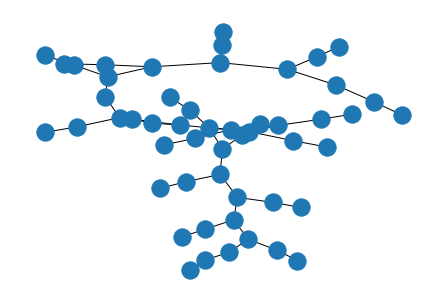

In [22]:
# draw graph of one of the LV grids
lv_grid = list(edisgo.topology.mv_grid.lv_grids)[5]
nx.draw(lv_grid.graph)

### Future generator scenario <a class="anchor" id="generator_scenario"></a>

eDisGo was originally developed in the [open_eGo](https://openegoproject.wordpress.com/) research project. In the open_eGo project two future scenarios, the 'NEP 2035' and the 'ego 100' scenario. The 'NEP 2035' scenario closely follows the B2-Scenario 2035 from the German network developement plan (Netzentwicklungsplan NEP) 2015. The share of renewables is 65.8%, electricity demand is assumed to stay the same as in the status quo. The 'ego 100' scenario is based on the e-Highway 2050 scenario and assumes a share of renewables of 100% and again an equal electricity demand as in the status quo.

As mentioned earlier, ding0 grids represent status quo networks with status quo generator capacities (base year is the year 2015). In order to analyse future scenarios future generators have to be imported into the network.

In [23]:
# Get installed capacity in Status Quo
edisgo.topology.generators_df.p_nom.sum()

26.084890999999992

In [24]:
# Import generators
scenario = "nep2035"
edisgo.import_generators(generator_scenario=scenario)
edisgo.set_time_series_worst_case_analysis()

In [25]:
# Get installed capacity in NEP 2035 scenario
edisgo.topology.generators_df.p_nom.sum()

74.35254833641072

Let's have a look at the MV grid topology in the NEP 2035 scenario:

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



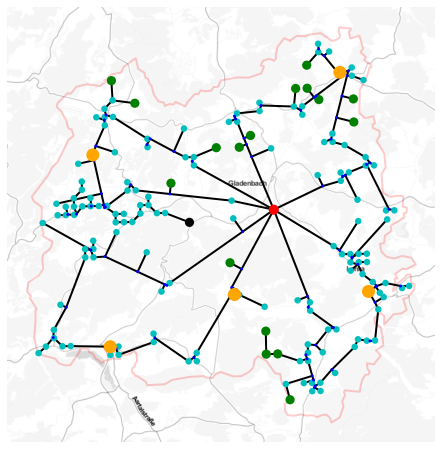

In [26]:
edisgo.plot_mv_grid_topology(technologies=True)

### Grid reinforcement <a class="anchor" id="grid_reinforcement"></a>

Now we can calculate grid expansion costs that arise from the integration of the new generators.

The grid expansion methodology is based on the distribution grid study of dena [[1]](#[1]) and Baden-Wuerttemberg [[2]](#[2]). The order grid expansion measures are conducted is as follows:

* Reinforce transformers and lines due to overloading issues
* Reinforce lines in MV grid due to voltage issues
* Reinforce distribution substations due to voltage issues
* Reinforce lines in LV grid due to voltage issues
* Reinforce transformers and lines due to overloading issues

Reinforcement of transformers and lines due to overloading issues is performed twice, once in the beginning and again after fixing voltage problems, as the changed power flows after reinforcing the grid may lead to new overloading issues. (For further explanation see the [documentation](http://edisgo.readthedocs.io/en/dev/features_in_detail.html#automatic-grid-expansion).)

After each reinforcement step a non-linear power flow analyses is conducted using PyPSA. Let's do a power flow analysis before the reinforcement to see how many over-loading and voltage issues there are.

In [27]:
# Do non-linear power flow analysis with PyPSA
edisgo.analyze()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00',
               '1970-01-01 02:00:00', '1970-01-01 03:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='H')
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.422223 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.430673 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.328522 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.337368 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq='H')

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



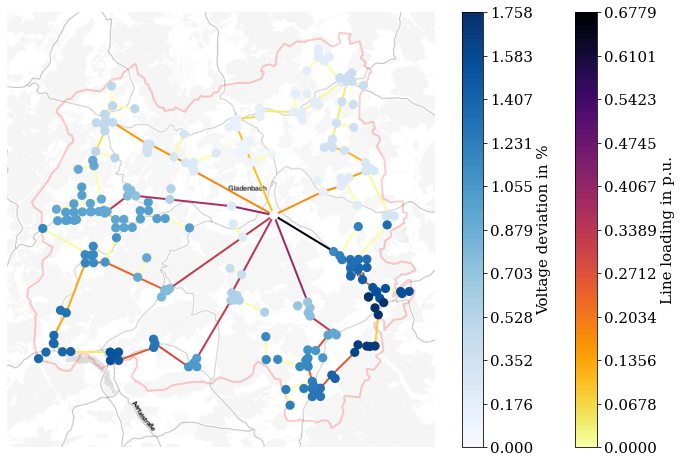

In [28]:
# feed-in case
edisgo.plot_mv_line_loading(
    node_color="voltage_deviation", timestep=edisgo.timeseries.timeindex[0]
)

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



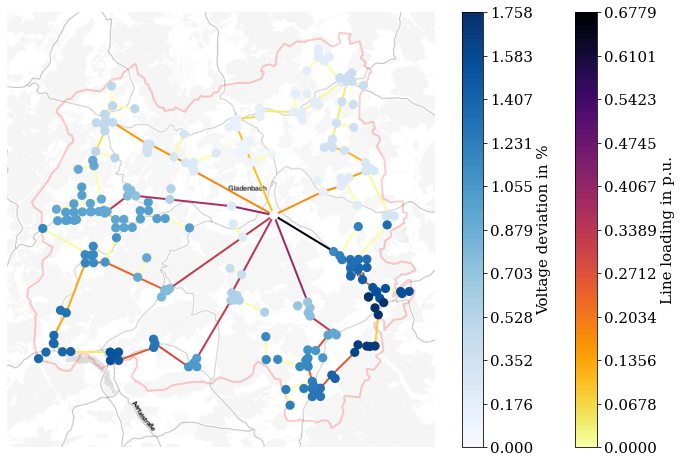

In [29]:
# load case
edisgo.plot_mv_line_loading(
    node_color="voltage_deviation", timestep=edisgo.timeseries.timeindex[1]
)

Let's check voltages and line loadings before the reinforcement.

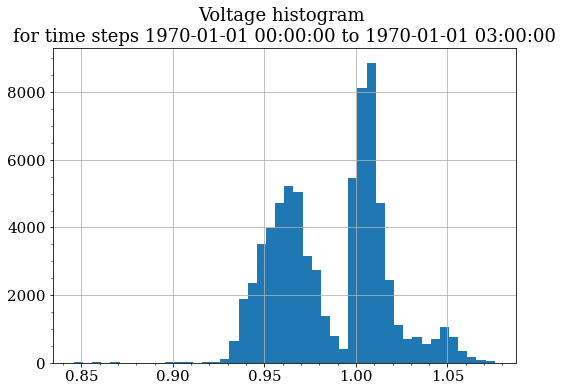

In [30]:
edisgo.histogram_voltage(binwidth=0.005)

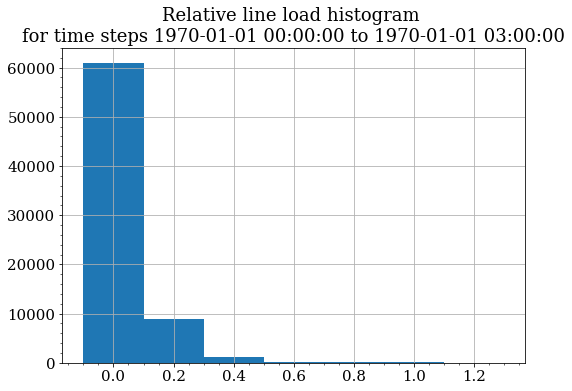

In [31]:
edisgo.histogram_relative_line_load(binwidth=0.2)

Reinforcement is invoked doing the following:

In [32]:
# Do grid reinforcement
edisgo.reinforce()

INFO:edisgo.edisgo:Running reinforcement in worst-case mode by differentiating between mv and lv load and feed-in cases.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 02:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.024126 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025066 seconds
/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning:

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Newton-Raphso

Let's check voltages and line loadings again:

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



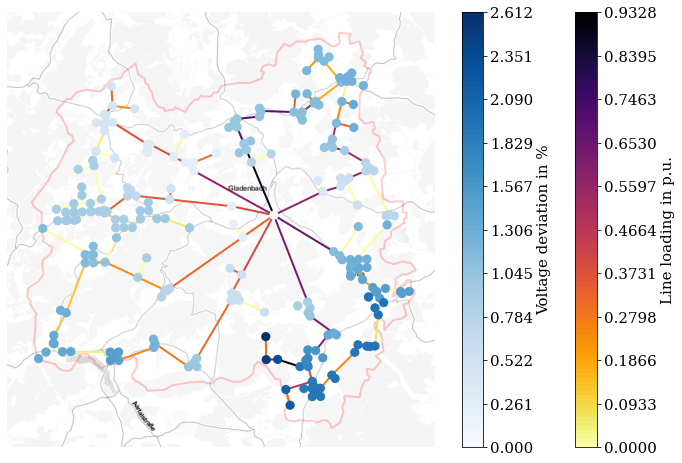

In [33]:
# load and feed-in case
edisgo.plot_mv_line_loading(node_color="voltage_deviation")

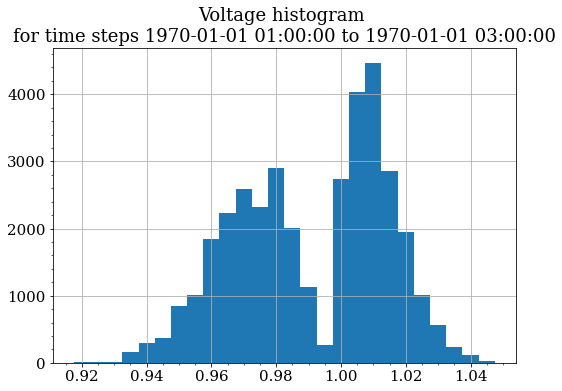

In [34]:
edisgo.histogram_voltage(binwidth=0.005)

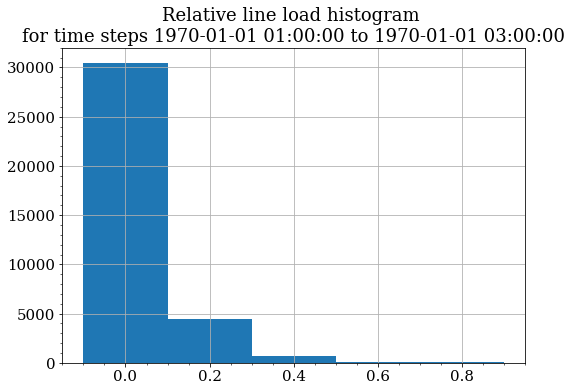

In [35]:
edisgo.histogram_relative_line_load(binwidth=0.2)

### Evaluate results <a class="anchor" id="evaluation"></a>

Results such as voltages at nodes and line loading from the power flow analysis as well as
grid expansion costs are provided through the [Results](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.results.Results) class. Above it was already shown how to access 
the results:

```python
edisgo.results
```

Get voltages at nodes through `v_res` attribute and line loading through `s_res` or `i_res` attribute.
The `equipment_changes` attribute holds details about measures performed during grid expansion. Associated costs can be obtained through the `grid_expansion_costs` attribute.

In [36]:
# Get voltages at nodes from last power flow analysis
edisgo.results.v_res

Bus,Busbar_mvgd_460_MV,BusBar_mvgd_460_lvgd_127330_MV,BusBar_mvgd_460_lvgd_127329_MV,BusBar_mvgd_460_lvgd_127331_MV,BusBar_mvgd_460_lvgd_127332_MV,BusBar_mvgd_460_lvgd_127333_MV,BusBar_mvgd_460_lvgd_402231_MV,BusBar_mvgd_460_lvgd_402819_MV,BusBar_mvgd_460_lvgd_399941_MV,BusBar_mvgd_460_lvgd_399742_MV,...,Bus_Generator_2609884,Bus_Generator_2609964,Bus_Generator_2609965,BranchTee_Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_131553_MVCableDist_mvgd_460_1_BusBar_mvgd_460_lvgd_131553_MV,Bus_Generator_2609966,BranchTee_Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_131199_MVCableDist_mvgd_460_9_BranchTee_mvgd_460_9,Bus_Generator_2609967,Bus_Generator_2609968,Bus_Generator_1705500,Bus_Generator_1705501
snapshot,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:00:00,1.0,0.99411,0.994346,0.994294,0.994101,0.993938,0.994549,0.992868,0.995216,0.991034,...,0.995317,0.995279,0.998115,0.998115,0.996265,0.996265,0.994549,0.995279,0.994428,0.989673
1970-01-01 03:00:00,1.0,1.01897,1.018875,1.018895,1.019002,1.018996,1.021031,1.019098,1.001498,1.001011,...,1.003551,1.024709,1.012054,1.011341,1.013288,1.012550,1.022036,1.026124,1.037846,1.032604


In [37]:
# View reinforced equipment
edisgo.results.equipment_changes.head()

,iteration_step,change,equipment,quantity
Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_136168_LVStation_mvgd_460_lvgd_401632_BusBar_mvgd_460_lvgd_401632_MV,0,added,NA2XS(FL)2Y 3x1x500 RM/35,1.0
Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_136168_LVStation_mvgd_460_lvgd_401632_BusBar_mvgd_460_lvgd_136168_MV,0,added,NA2XS(FL)2Y 3x1x500 RM/35,1.0
Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_136168_LVStation_mvgd_460_lvgd_401632_Bus_Generator_2609878,0,added,NA2XS2Y 3x1x150 RE/25,1.0
Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_131553_MVCableDist_mvgd_460_1_BranchTee_mvgd_460_1,0,added,NA2XS(FL)2Y 3x1x500 RM/35,1.0
Line_BranchTee_Branch_LVStation_mvgd_460_lvgd_131553_MVCableDist_mvgd_460_1_Bus_Generator_2609879,0,added,NA2XS2Y 3x1x150 RE/25,1.0


In [38]:
# Get costs in kEUR for reinforcement per equipment
costs = edisgo.results.grid_expansion_costs
costs.head()

,type,total_costs,quantity,voltage_level,length
Transformer_lv_grid_133650_reinforced_2,0.16 MVA 20/0.4 kV,10.0,1.0,mv/lv,NaN
Transformer_lv_grid_133653_reinforced_2,0.16 MVA 20/0.4 kV,10.0,1.0,mv/lv,NaN
Transformer_lv_grid_134678_reinforced_2,0.1 MVA 20/0.4 kV,10.0,1.0,mv/lv,NaN
Transformer_lv_grid_134203_reinforced_1,630 kVA,10.0,1.0,mv/lv,NaN
Transformer_lv_grid_133183_reinforced_2,0.4 MVA 20/0.4 kV,10.0,1.0,mv/lv,NaN


In [39]:
# Group costs by voltage level
costs_grouped_nep = costs.groupby(["voltage_level"]).sum()
costs_grouped_nep.loc[:, ["total_costs"]]

,total_costs
voltage_level,
lv,464.106722
mv,3565.954968
mv/lv,760.000000


An overview of the assumptions used to calculate grid expansion costs can be found in the [documentation]( http://edisgo.readthedocs.io/en/dev/features_in_detail.html#grid-expansion-costs).

You can also view grid expansion costs for equipment in the MV using the following plot:

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/birgit/virtualenvs/edisgo_emob/git_repos/eDisGo/edisgo/tools/plots.py:524: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



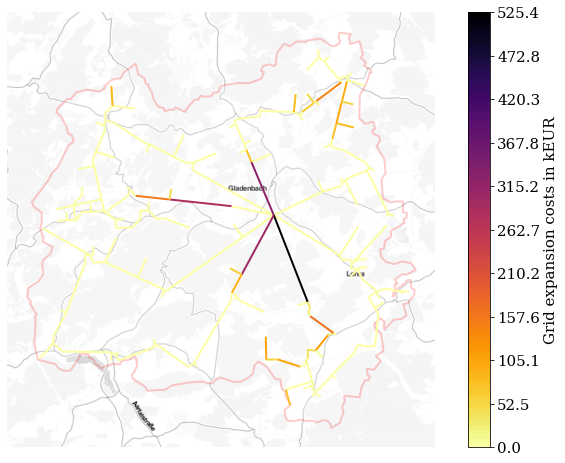

In [40]:
edisgo.plot_mv_grid_expansion_costs()

Results can be saved to csv files with:

```python
edisgo.results.save('path/to/results/directory/')
```

Now let's compare the grid expansion costs for the 'NEP 2035' scenario with grid expansion costs for the 'ego 100' scenario. Therefore, we first have to setup the new scenario and calculate grid expansion costs.

In [ ]:
# initialize new EDisGo object with 'ego 100' scenario
edisgo_ego100 = EDisGo(
    ding0_grid=ding0_grid,
    generator_scenario="ego100",
)
edisgo_ego100.set_time_series_worst_case_analysis()
# conduct grid reinforcement
edisgo_ego100.reinforce()

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version None.

INFO:pypsa.io:Imported network ding0_test_network has buses, generators, lines, loads, transformers
/home/birgit/virtualenvs/edisgo_emob/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:edisgo.edisgo:Running reinforcement in worst-case mode by differentiating between mv and lv load and feed-in cases.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['

In [ ]:
# get grouped costs
costs_grouped_ego100 = edisgo_ego100.results.grid_expansion_costs.groupby(
    ["voltage_level"]
).sum()
costs_grouped_ego100.loc[:, ["total_costs"]]

In [ ]:
# compare expansion costs for both scenarios in a plot
# set up dataframe to plot
costs_df = (
    costs_grouped_nep.loc[:, ["total_costs"]]
    .join(
        costs_grouped_ego100.loc[:, ["total_costs"]],
        rsuffix="_ego100",
        lsuffix="_nep2035",
    )
    .rename(columns={"total_costs_ego100": "ego100", "total_costs_nep2035": "NEP2035"})
    .T
)
# plot
costs_df.plot(kind="bar", stacked=True)
plt.xticks(rotation=0)
plt.ylabel("Grid reinforcement costs in k€");

## References <a class="anchor" id="references"></a>

<a class="anchor" id="[1]"></a> [1] A.C. Agricola et al.: dena-Verteilnetzstudie: Ausbau- und Innovationsbedarf der Stromverteilnetze in Deutschland bis 2030. 2012.

<a class="anchor" id="[2]"></a> [2] C. Rehtanz et al.: Verteilnetzstudie für das Land Baden-Württemberg, ef.Ruhr GmbH, 2017.